# Funnel Target: Compare SGLD and Neural Wasserstein Gradient Flow of the KL

In [1]:
# # for leonhard
# import os
# os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=" + os.environ["CUDA_HOME"]
# os.environ['XLA_FLAGS']

In [99]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", False)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("../../experiments/")
from matplotlib.animation import FuncAnimation

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd

import utils
import plot
import distributions
import models
import flows
from tqdm import tqdm
key = random.PRNGKey(0)

import kernels
import metrics
# import seaborn as sns
# sns.set_theme()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
# # set up exporting
# import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
# #     'font.family': 'serif',
# #     'text.usetex': True,
#     'pgf.rcfonts': False,
#     'axes.unicode_minus': False, # avoid unicode error on saving plots with negative numbers (??)
# })

# # figure_path = "/home/lauro/documents/msc-thesis/thesis/figures/"
# figure_path = "/home/lauro/documents/msc-thesis/paper/latex/figures/"

# # save figures by using plt.savefig('path/to/fig')
# # remember that latex textwidth is 5.4in
# # so use figsize=[5.4, 4], for example
# printsize = [5.4, 4]

# 2dim Funnel

In [101]:
n_steps = 5000 # 5000
particle_lr = 1e-2
learner_lr = 1e-4
n_particles = 100
d = 2
PATIENCE = 10

In [174]:
target = distributions.Funnel(d)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
funnel_setup = distributions.Setup(target, proposal)
target_samples = target.sample(n_particles*3)

In [103]:
key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, n_learner_steps=100, patience=PATIENCE, learning_rate=learner_lr, aux=False, dropout=False, compute_metrics=metrics.get_funnel_tracer(target_samples))
# sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, compute_metrics=metrics.get_funnel_tracer(target_samples))
# sgld_gradient2, sgld_particles2, err4    = flows.sgld_flow(     subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr/5, compute_metrics=metrics.get_funnel_tracer(target_samples))
# svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr*5, scaled=True,  bandwidth=None, compute_metrics=metrics.get_funnel_tracer(target_samples))

# Note: I scaled the svgd step-size (by hand) so that it is maximial while still converging to a low MMD.

100%|██████████| 5000/5000 [02:27<00:00, 33.83it/s]


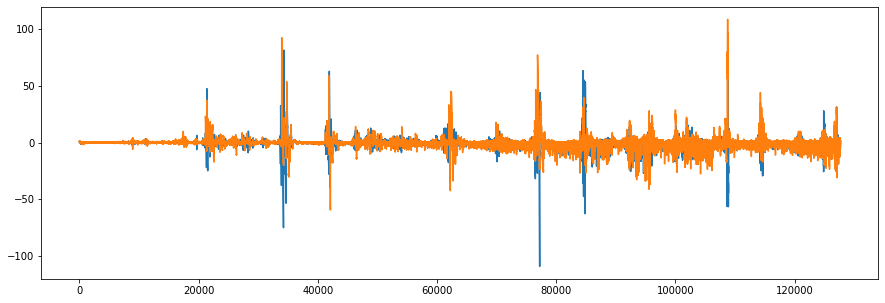

In [104]:
%matplotlib inline
plt.subplots(figsize=[15, 5])
plt.plot(neural_learner.rundata["loss"])
plt.plot(neural_learner.rundata["val_loss"])

In [105]:
diffs = onp.array(neural_learner.rundata['l1_diff'])
ratios = onp.array(neural_learner.rundata['l1_ratio'])

idx = onp.cumsum(neural_learner.rundata['train_steps']) - 1
# idx = onp.arange(199, len(diffs), 200)

end_diffs = diffs[idx]
end_ratios = ratios[idx]

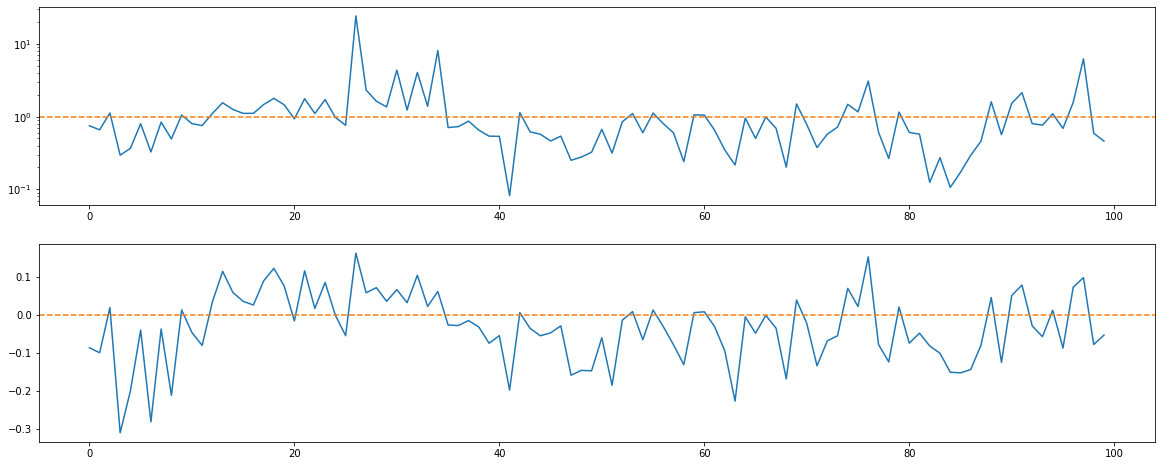

In [106]:
fig, axs = plt.subplots(2, figsize=[20, 8])
b = 100

ax = axs[0]
ax.plot(end_ratios[:b])
ax.axhline(y=1, linestyle='--', color='tab:orange')
ax.set_yscale('log')

ax = axs[1]
ax.plot(end_diffs[:b])
ax.axhline(y=0, linestyle='--', color='tab:orange')

In [107]:
neural_learner.rundata.keys()

dict_keys(['train_steps', 'global_gradient_norm', 'l1_diff', 'l1_ratio', 'l2', 'loss', 'sd', 'val_l1_diff', 'val_l1_ratio', 'val_l2', 'val_loss', 'val_sd'])

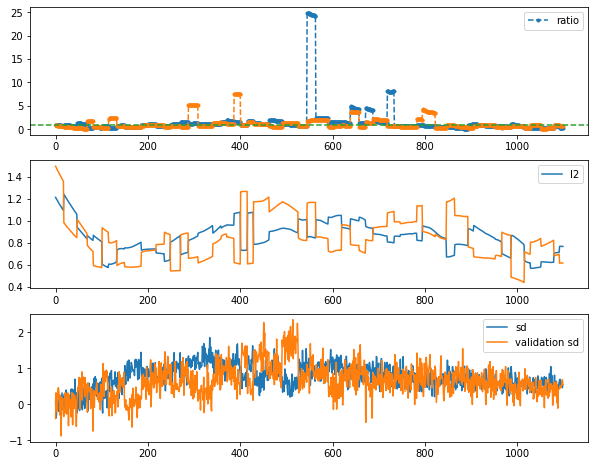

In [108]:
a = 0
b = 1100

fig, axs = plt.subplots(3, figsize=[10, 8])

ax = axs[0]
ax.plot(neural_learner.rundata['l1_ratio'][a:b], "--.", label='ratio')
ax.plot(neural_learner.rundata['val_l1_ratio'][a:b], "--.")
ax.axhline(y=1, linestyle='--', color='tab:green')
ax.legend()

ax = axs[1]
ax.plot(neural_learner.rundata['l2'][a:b], label='l2')
ax.plot(neural_learner.rundata['val_l2'][a:b])
ax.legend()

ax = axs[2]
ax.plot(neural_learner.rundata['sd'][a:b], label='sd')
ax.plot(neural_learner.rundata['val_sd'][a:b], label='validation sd')
ax.legend()

In [109]:
len(neural_learner.rundata['train_steps'])

5000

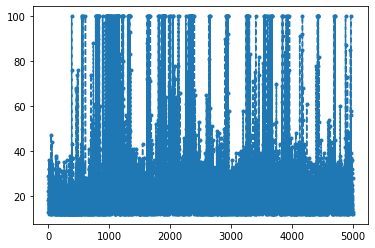

In [110]:
plt.plot(neural_learner.rundata['train_steps'], '--.')

### Sequential Langevin MMD

In [111]:
key, subkey = random.split(key)

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

target_log_prob = target.logpdf

# kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(target_log_prob_fn=target_log_prob, step_size=1e-2)
# kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-3)
kernel = tfp.mcmc.UncalibratedLangevin(target_log_prob_fn=target_log_prob, step_size=particle_lr/5)

@jit
def run_chain(key, state):
    return tfp.mcmc.sample_chain(1_000_000,
      current_state=state,
      kernel=kernel,
      trace_fn = None,
#       trace_fn=lambda _, results: results.target_log_prob,
      num_burnin_steps=0,
      seed=key)

In [112]:
key, subkey = random.split(key)
single_chain_init = proposal.sample(1, subkey)[0]
key, subkey = random.split(key)
single_chain = run_chain(subkey, single_chain_init)

mmd = metrics.get_mmd(kernel=kernels.get_funnel_kernel(1.))

@jit
def get_single_chain_mmd(key):
    key, subkey = random.split(key)
    single_chain_init = proposal.sample(1, subkey)[0]
    key, subkey = random.split(key)
    single_chain = run_chain(subkey, single_chain_init)

    spaced_samples = single_chain[np.arange(0, 1_000_000, 1000)]
    return mmd(target_samples, spaced_samples)


key, subkey = random.split(key)
get_single_chain_mmd(subkey)

mmds = []

for _ in range(10):
    key, subkey = random.split(key)
    mmds.append(get_single_chain_mmd(subkey))

sequential_mmd = onp.mean(mmds)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:327: UserWarning: supplied `TransitionKernel` is not calibrated. Markov chain may not converge to intended target distribution.
  warnings.warn('supplied `TransitionKernel` is not calibrated. Markov '
/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:327: UserWarning: supplied `TransitionKernel` is not calibrated. Markov chain may not converge to intended target distribution.
  warnings.warn('supplied `TransitionKernel` is not calibrated. Markov '


In [113]:
neural_particles.rundata[typ+'mmd'].shape

(500, 2)

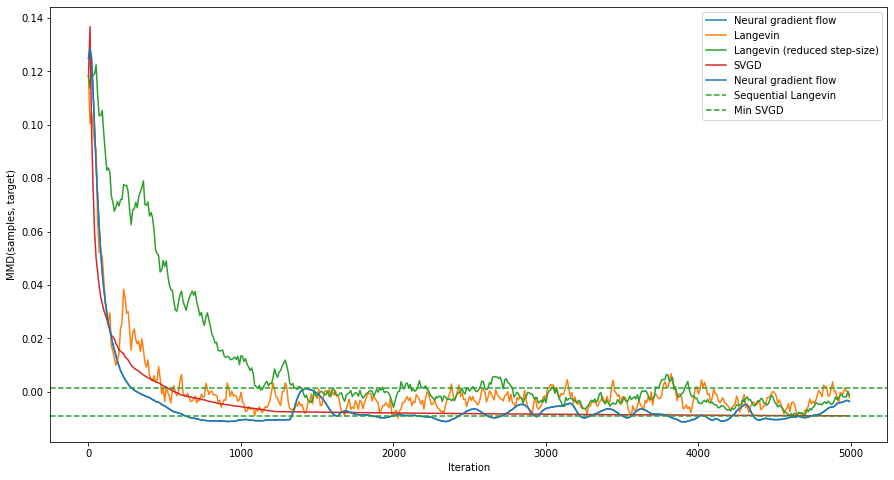

In [165]:
%matplotlib inline
plt.subplots(figsize=[15, 8])

b = 500
typ = "rbf_"

plt.plot(*zip(*neural_particles.rundata[typ+"mmd"][:b]), label="Neural gradient flow")
plt.plot(*zip(*sgld_particles.rundata[typ+"mmd"][:b]), label="Langevin")
plt.plot(*zip(*sgld_particles2.rundata[typ+"mmd"][:b]), label="Langevin (reduced step-size)")
plt.plot(*zip(*svgd_particles.rundata[typ+"mmd"][:b]), label="SVGD")
plt.plot(*zip(*neural_particles.rundata[typ+"mmd"][:b]), label="Neural gradient flow", color="tab:blue")

plt.axhline(y=sequential_mmd, label="Sequential Langevin", color="tab:green", linestyle="--")
plt.axhline(y=svgd_particles.rundata[typ+"mmd"][-1][1], label="Min SVGD", color="tab:green", linestyle="--")

plt.xlabel("Iteration")
plt.ylabel("MMD(samples, target)")

plt.legend()

In [170]:
snapshot = neural_particles.rundata['particles'][1000]

In [97]:
# # save results
# import config as cfg
# import json_tricks as json

# particle_containers = (neural_particles, sgld_particles,
#                        sgld_particles2, svgd_particles)
# names = ("NVGD", "SGLD", "SGLD2", "SVGD")
# results = {name: p.rundata["rbf_mmd"].tolist()  # CHANGED from 'funnel_mmd'
#            for name, p in zip(names, particle_containers)}

# results.update({"sequential": sequential_mmd})

# with open(cfg.results_path + "funnel-mmd-comparison.json", "w") as f:
#     json.dump(results, f, indent=4, sort_keys=True)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/json_tricks/encoders.py:367: UserWarning: json-tricks: numpy scalar serialization is experimental and may work differently in future versions
  warnings.warn('json-tricks: numpy scalar serialization is experimental and may work differently in future versions')


In [183]:
# # save scatterplot results
# samples = (neural_particles.particles, sgld_particles.particles, target_samples)
# names = ("NVGD", "SGLD", "true")
# results = {
#     name: s.tolist() for name, s in zip(names, samples)
# }

# with open(cfg.results_path + "funnel-scatter.json", "w") as f:
#     json.dump(results, f, indent=4, sort_keys=True)

# Plots

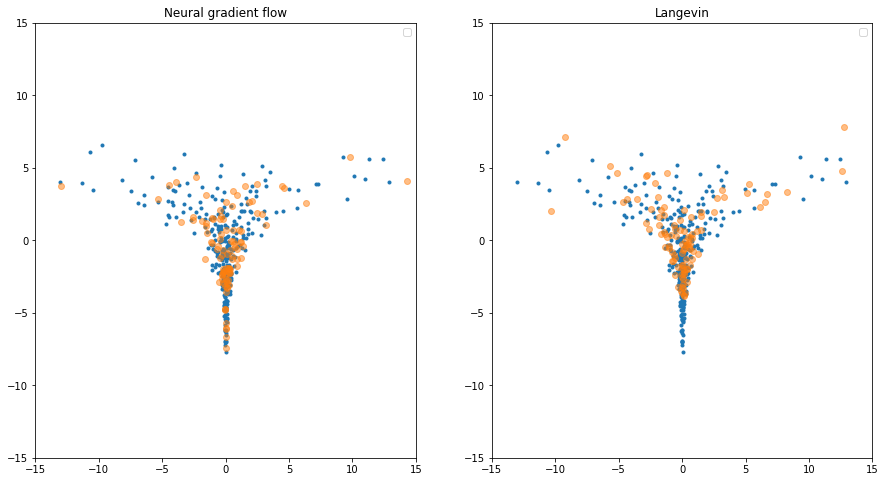

In [175]:
%matplotlib inline
lims=(-15, 15)

fig, axs = plt.subplots(1, 2, figsize=[15, 8])
titles = ("Neural gradient flow", "Langevin")
sample_list = [p.particles for p in (neural_particles, sgld_particles)]

# sample_list[0] = snapshot

for samples, ax, title in zip(sample_list, axs.flatten(), titles):
    ax.scatter(*onp.rollaxis(target_samples, 1), alpha=1, marker=".")
    ax.scatter(*onp.rollaxis(samples, 1), alpha=0.5)
    ax.legend()
    ax.set_title(title)
    ax.set(xlim=lims, ylim=lims)

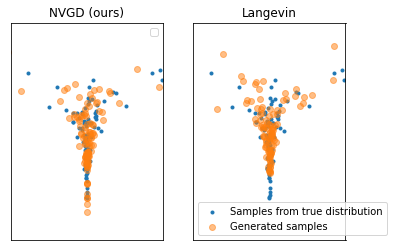

In [164]:
printsize_singlecolumn = [6, 4]

figure_path = '/home/lauro/documents/msc-thesis/paper/latex/figures/'

%matplotlib inline
lims=(-15, 15)

fig, axs = plt.subplots(1, 2, figsize=printsize_singlecolumn)
titles = ("NVGD (ours)", "Langevin")
sample_list = [p.particles for p in (neural_particles, sgld_particles)]

# plt.tick_params(
#     axis='both',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False)


for samples, ax, title in zip(sample_list, axs.flatten(), titles):
    # labels
    l1 = "Samples from true distribution" if title=="Langevin" else None
    l2 = "Generated samples" if title=="Langevin" else None
    ax.set_xticks([])
    ax.set_yticks([])
#     ax.tick_params()
    ax.scatter(*onp.rollaxis(target_samples, 1), alpha=1, marker=".", label=l1)
    ax.scatter(*onp.rollaxis(samples, 1), alpha=0.5, marker="o", label=l2)
    ax.legend()
    ax.set_title(title)
    ax.set(xlim=lims, ylim=(-10, 10))

# plt.savefig(figure_path + "funnel_scatter.pgf", bbox_inches='tight')

### animate projection

In [14]:
idx = np.array([0, -1])

In [15]:
neural_particles.rundata.keys()

dict_keys(['particles', 'step', 'test_mean', 'test_std', 'training_mean', 'training_std', 'rbf_mmd', 'funnel_mmd'])

In [16]:
trajectory = neural_particles.rundata["particles"].training
trajectory_projected = trajectory[:, :, idx]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

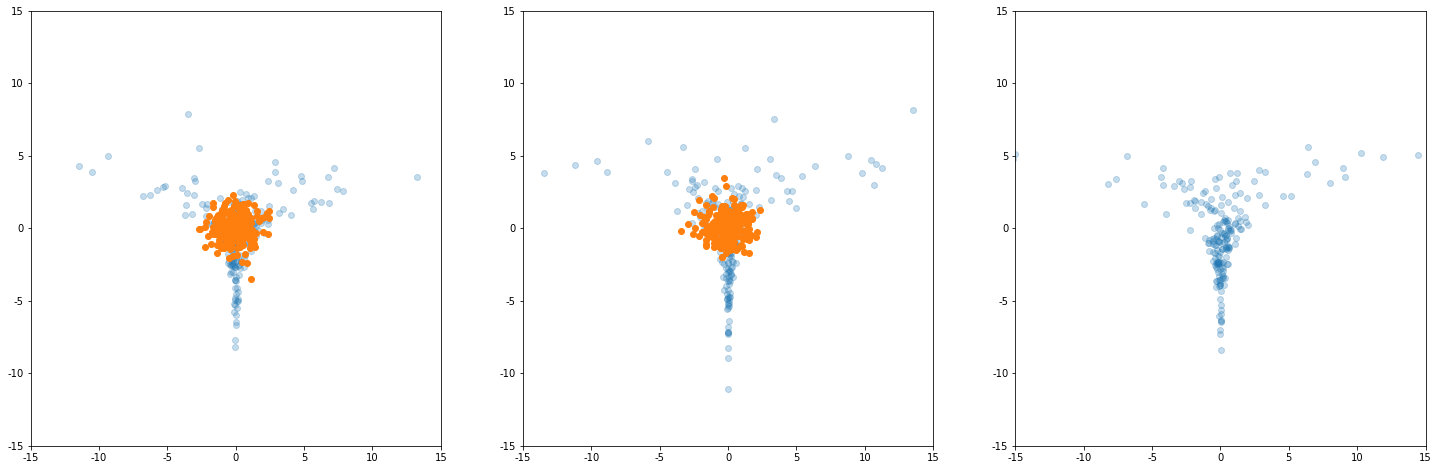

In [21]:
%matplotlib widget
lims = (-15, 15)
fig, axs = plt.subplots(1, 3, figsize=[25,8])
for ax in axs:
    ax.scatter(*np.rollaxis(target.sample(n_particles)[:, idx], 1), label="True", alpha=0.25)
    ax.set(xlim=lims, ylim=lims)


interval = 10
a=[]
a.append(plot.animate_array(trajectory_projected, fig, ax=axs[0], interval=interval))
a.append(plot.animate_array(sgld_particles.rundata["particles"].training, ax=axs[1], interval=interval))
# a.append(plot.animate_array(sgld_particles2.rundata["particles"].training, ax=axs[2], interval=interval))
a

In [15]:
from celluloid import Camera
writer = matplotlib.animation.writers['ffmpeg'](fps=30)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

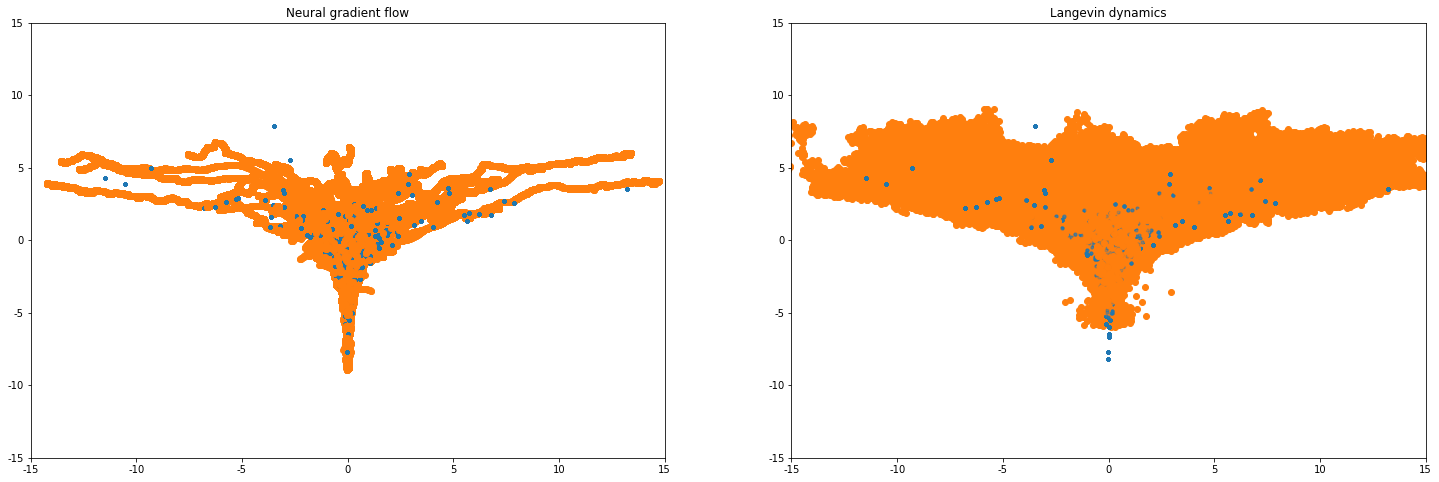

In [19]:
%matplotlib widget
lims = (-15, 15)
fig, axs = plt.subplots(1, 2, figsize=[25,8])
axs[0].set_title("Neural gradient flow")
axs[1].set_title("Langevin dynamics")

camera = Camera(fig)


for t in range(5000):
    sample_list = [p.rundata["particles"].training[t] for p in (neural_particles, sgld_particles)]
    for ax, samples in zip(axs, sample_list):
        plot_true(ax=ax)
        ax.scatter(*np.rollaxis(samples, 1), color="tab:orange")
    camera.snap()

anim = camera.animate()

In [20]:
anim.save("ngf-vs-pula.mp4", writer=writer, dpi=200)

# same thing but plus SVGD

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

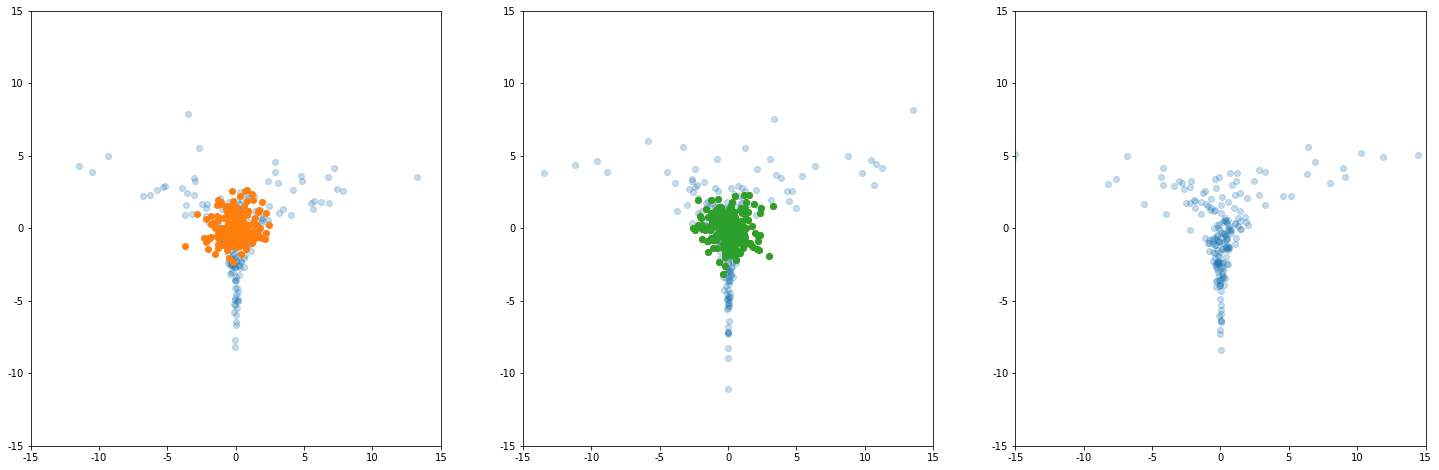

In [17]:
%matplotlib widget
lims = (-15, 15)
fig, axs = plt.subplots(1, 3, figsize=[25,8])
for ax in axs:
    ax.scatter(*np.rollaxis(target.sample(n_particles)[:, idx], 1), label="True", alpha=0.25)
    ax.set(xlim=lims, ylim=lims)


interval = 10
a=[]
a.append(plot.animate_array(trajectory_projected, fig, ax=axs[0], interval=interval))
a.append(plot.animate_array(sgld_particles.rundata["particles"].training, ax=axs[1], interval=interval))
# a.append(plot.animate_array(sgld_particles2.rundata["particles"].training, ax=axs[2], interval=interval))
a.append(plot.animate_array(svgd_particles.rundata["particles"].training, ax=axs[1], interval=interval)) # ADDED SVGD
a

In [18]:
from celluloid import Camera
writer = matplotlib.animation.writers['ffmpeg'](fps=30)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

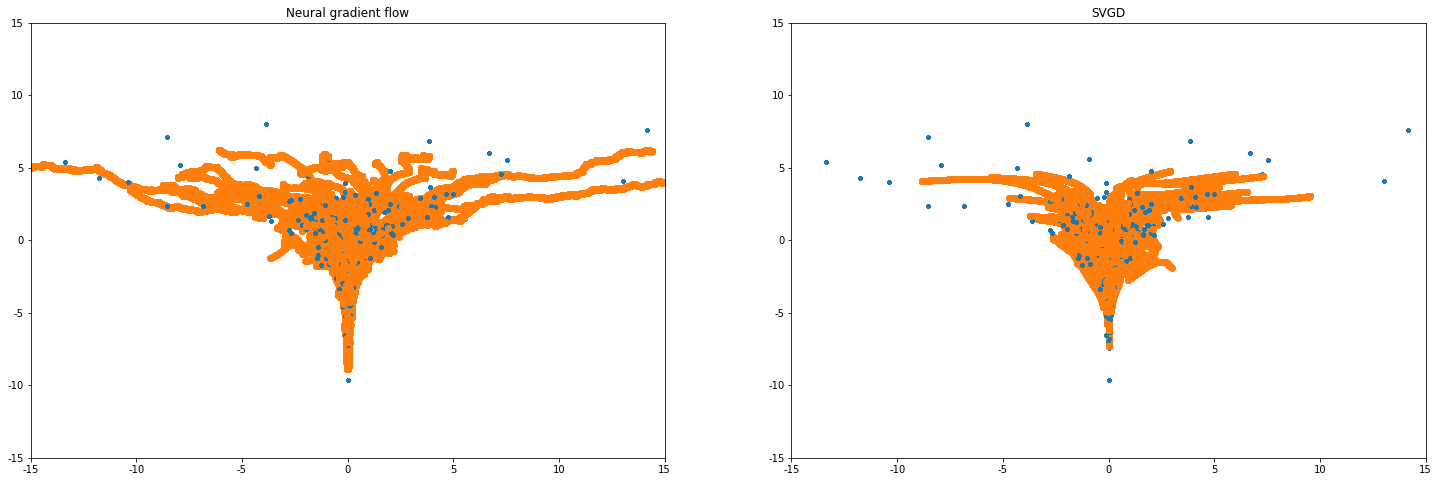

In [19]:
%matplotlib widget
lims = (-15, 15)
fig, axs = plt.subplots(1, 2, figsize=[25,8])
axs[0].set_title("Neural gradient flow")
# axs[1].set_title("Langevin dynamics")
axs[1].set_title("SVGD")
camera = Camera(fig)

ps = (neural_particles, svgd_particles)
# ps = (neural_particles, sgld_particles)
for t in range(5000):
    sample_list = [p.rundata["particles"].training[t] for p in ps]
    for ax, samples in zip(axs, sample_list):
        plot_true(ax=ax)
        ax.scatter(*np.rollaxis(samples, 1), color="tab:orange")
    camera.snap()

anim = camera.animate()

In [20]:
anim.save("ngf-vs-svgd.mp4", writer=writer, dpi=200)

# Same thing with `TFP`

In [87]:
key, subkey = random.split(key)

In [88]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

In [89]:
d = 2
dfunnel = distributions.Funnel(d)
dproposal = distributions.Gaussian(np.ones(d), 1)
target_log_prob = dfunnel.logpdf

# kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(target_log_prob_fn=target_log_prob, step_size=1e-2)
# kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-3)
kernel = tfp.mcmc.UncalibratedLangevin(target_log_prob_fn=target_log_prob, step_size=particle_lr/5)

@jit
def run_chain(key, state):
    return tfp.mcmc.sample_chain(1_000_000,
      current_state=state,
      kernel=kernel,
      trace_fn = None,
#       trace_fn=lambda _, results: results.target_log_prob,
      num_burnin_steps=0,
      seed=key)

In [101]:
key, subkey = random.split(key)
single_chain_init = dproposal.sample(1, subkey)[0]
key, subkey = random.split(key)
single_chain = run_chain(subkey, single_chain_init)

In [ ]:
mmd = metrics.get_mmd(kernel=kernels.get_funnel_kernel(1.))

In [112]:
@jit
def get_single_chain_mmd(key):
    key, subkey = random.split(key)
    single_chain_init = dproposal.sample(1, subkey)[0]
    key, subkey = random.split(key)
    single_chain = run_chain(subkey, single_chain_init)

    spaced_samples = single_chain[np.arange(0, 1_000_000, 1000)]
    return mmd(target_samples, spaced_samples)

In [115]:
key, subkey = random.split(key)
get_single_chain_mmd(subkey)

DeviceArray(-0.0006852, dtype=float32)

In [ ]:
mmds = []

In [126]:
for _ in range(10):
    key, subkey = random.split(key)
    mmds.append(get_single_chain_mmd(subkey))

In [129]:
sequential_mmd = onp.mean(mmds)

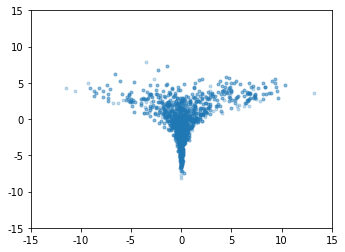

In [98]:
%matplotlib inline
fig, ax = plt.subplots(figsize=printsize)
plot_true(ax=ax)
plot.scatter(spaced_samples, ax=ax, alpha=0.5, marker=".")
# plt.savefig(figure_path + "sequential_ula_funnel_scatter.pgf")

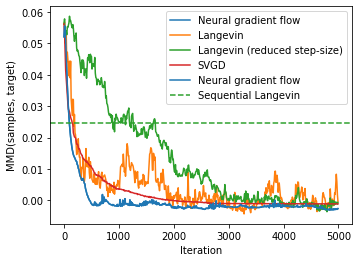

In [130]:
%matplotlib inline
plt.subplots(figsize=printsize)

typ = "funnel_"

plt.plot(*zip(*neural_particles.rundata[typ+"mmd"]), label="Neural gradient flow")
plt.plot(*zip(*sgld_particles.rundata[typ+"mmd"]), label="Langevin")
plt.plot(*zip(*sgld_particles2.rundata[typ+"mmd"]), label="Langevin (reduced step-size)")
plt.plot(*zip(*svgd_particles.rundata[typ+"mmd"]), label="SVGD")
plt.plot(*zip(*neural_particles.rundata[typ+"mmd"]), label="Neural gradient flow", color="tab:blue")

plt.axhline(y=sequential_mmd, label="Sequential Langevin", color="tab:green", linestyle="--")

plt.xlabel("Iteration")
plt.ylabel("MMD(samples, target)")

plt.legend()

# plt.savefig(figure_path + "funnel_mmd.pgf")

In [ ]:
# %matplotlib widget
# fig, ax = plt.subplots(figsize=[7,7])
# plot_true(ax=ax)
# plot.animate_array(single_chain[:, None, :], interval=1)

In [ ]:
sdjkfdk

# same thing in 3D

In [ ]:
%autoreload

In [ ]:
particle_lr = 5e-3
learner_lr = 5e-5
n_particles = 200
d = 25
PATIENCE = 0
# PATIENCE = 15 # try this

In [ ]:
target = distributions.Funnel(d)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
funnel_setup = distributions.Setup(target, proposal)
target_samples = target.sample(500)

In [ ]:
target_moment2 = np.array([9] + (d-1)*[90])

In [ ]:
key, subkey = random.split(key)
neural_learner_d, neural_particles_d, err1 = flows.neural_svgd_flow(subkey, funnel_setup, n_particles=n_particles, n_steps=2000, particle_lr=particle_lr, patience=PATIENCE, learner_lr=learner_lr, aux=False, compute_metrics=metrics.get_2nd_moment_tracer(target_moment2))
sgld_gradient_d, sgld_particles_d, err3    = flows.sgld_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=2000, particle_lr=particle_lr, compute_metrics=metrics.get_2nd_moment_tracer(target_moment2))
# sgld_gradient2_d, sgld_particles2_d, err4    = flows.sgld_flow(     subkey, funnel_setup, n_particles=n_particles, n_steps=10000, particle_lr=particle_lr/5, compute_metrics=metrics.get_2nd_moment_tracer(target_moment2))

In [ ]:
%matplotlib inline
plt.subplots(figsize=[15, 8])

plt.plot(*zip(*neural_particles_d.rundata["second_error"]), label="Neural")
plt.plot(*zip(*sgld_particles_d.rundata["second_error"]), label="SGLD")
# plt.plot(*zip(*sgld_particles2_d.rundata["second_error"]), label="SGLD (reduced step-size)")
# plt.plot(*zip(*svgd_particles.rundata["second_error"]), label="SVGD")
# plt.yscale("symlog")

plt.xlabel("Iteration")
plt.ylabel("MMD(samples, target)")

plt.legend()

In [ ]:
%matplotlib inline
plt.subplots(figsize=printsize)

typ = "funnel_"

plt.plot(*zip(*neural_particles_d.rundata[typ+"mmd"]), label="Neural gradient flow")
plt.plot(*zip(*sgld_particles_d.rundata[typ+"mmd"]), label="Langevin")
# plt.plot(*zip(*sgld_particles2_d.rundata[typ+"mmd"]), label="Langevin (reduced step-size)")
# plt.plot(*zip(*svgd_particles.rundata[typ+"mmd"]), label="SVGD")
plt.legend()

plt.xlabel("Iteration")
plt.ylabel("MMD(samples, target)")

# plt.savefig(figure_path + "funnel_mmd_3d.pgf")

In [ ]:
sgld_particles_d.particles.training[:, idx].shape

In [ ]:
np.rollaxis(sgld_particles_d.particles.training[:, idx], 1).shape

In [ ]:
idx = np.array([0, -1])
plot_true(idx)
plt.scatter(*np.rollaxis(sgld_particles_d.particles.training[:, idx], 1), alpha=0.9)

In [ ]:
def plot_projection(idx, figsize=[20, 5]):
    sample_list = [p.particles.training for p in (neural_particles_d, sgld_particles_d)]
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    titles = ("Neural gradient flow", "Langevin") #+ ("Langevin (smaller stepsize)",)
    for samples, ax, title in zip(sample_list, axs.flatten(), titles):
        plot_true(idx, ax)
        ax.scatter(*np.rollaxis(samples[:, idx], 1), alpha=0.9)
        ax.legend()
        ax.set_title(title)
        ax.set(xlim=lims, ylim=lims)

In [ ]:
%matplotlib inline
lims=(-15, 15)

idx = np.array([0, -1])
plot_projection(idx, figsize=[20, 8])

In [ ]:
idx = np.array([0, -1])
plot_projection(idx, figsize=printsize)
# plt.savefig(figure_path + "funnel_scatter_3d.pgf")

# Animation

In [ ]:
idx = np.array([0, -1])

In [ ]:
# %matplotlib widget
# lims = (-15, 15)
# fig, axs = plt.subplots(1, 3, figsize=[25,8])
# for ax in axs:
#     plot_true(ax=ax)
    
# interval = 1
# a=[]
# a.append(plot.animate_array(neural_particles_d.rundata["particles"].training[:, :, idx], fig, ax=axs[0], interval=interval))
# a.append(plot.animate_array(  sgld_particles_d.rundata["particles"].training[:, :, idx], fig, ax=axs[1], interval=interval))
# # a.append(plot.animate_array(sgld_particles2.rundata["particles"].training, ax=axs[2], interval=interval))
# a